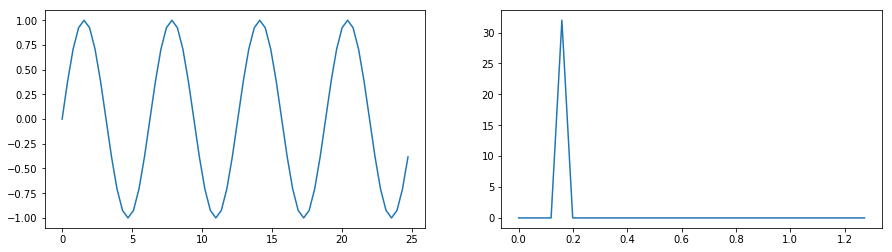

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Sine wave is continuous from last sample to first.

fig,ax = plt.subplots(1,2, figsize=(15,4))

x = np.arange(0,8*np.pi,(8*np.pi)/64)
y = np.sin(x)
ax[0].plot(x,y)

f = np.fft.rfft(y)
fx = np.fft.rfftfreq(len(y),x[1]-x[0])
ax[1].plot(fx,abs(f))
plt.show()

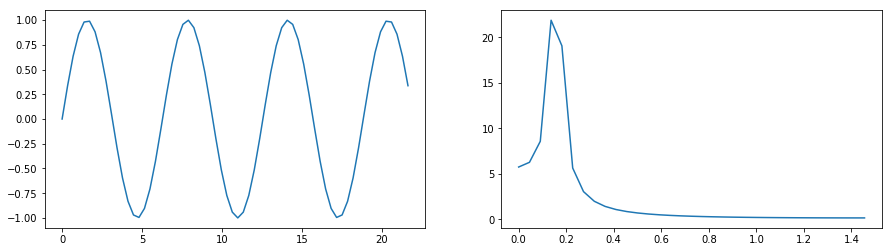

In [9]:
# Sine wave is not continuous from last sample to first. Spectral energy is spread among many nearby bins!

fig,ax = plt.subplots(1,2, figsize=(15,4))

x = np.arange(0,7*np.pi,(7*np.pi)/64)
y = np.sin(x)
ax[0].plot(x,y)

f = np.fft.rfft(y)
fx = np.fft.rfftfreq(len(y),x[1]-x[0])
ax[1].plot(fx,abs(f))
plt.show()

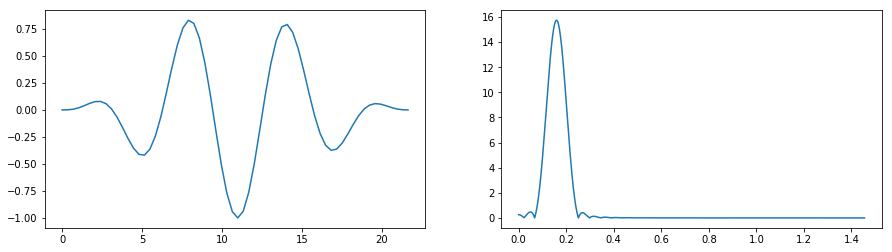

In [33]:
# Apply some "window" to the wave so that it goes to zero at the boundaries. That ensures it is continuous.
fig,ax = plt.subplots(1,2, figsize=(15,4))

x = np.arange(0,7*np.pi,(7*np.pi)/64)
y = np.sin(x)*np.hanning(len(x))
ax[0].plot(x,y)

dx = x[1]-x[0]
NFFT=(2**18)

f = np.fft.rfft(np.concatenate((y,np.zeros(NFFT-len(y)))))
fx = np.fft.rfftfreq(NFFT,x[1]-x[0])
ax[1].plot(fx,abs(f))
plt.show()

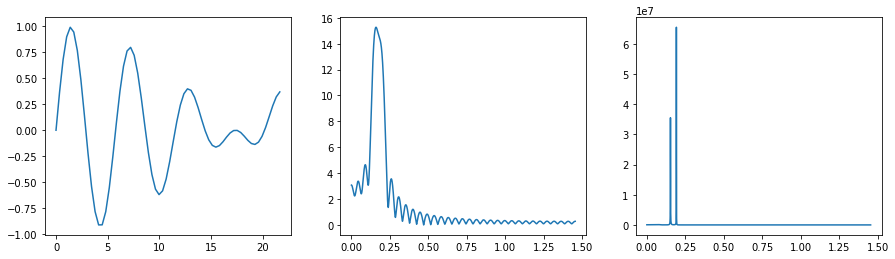

In [32]:
# Two sine waves of closely related frequencies are difficult to separate.

from spectrum import pyule
x = np.arange(0,7*np.pi,(7*np.pi)/64)
y = 0.5*np.sin(x)+0.5*np.sin(1.18*x)

dx = x[1]-x[0]
NFFT=(2**18)

fig,ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(x,y)

f = np.fft.rfft(np.concatenate((y,np.zeros(NFFT-len(y)))))
fx = np.fft.rfftfreq(NFFT,x[1]-x[0])
ax[1].plot(fx,abs(f))

# AR filter implements maximum entropy frequency solution
ar = pyule(y, int(len(y)/2), norm='unbiased', NFFT=NFFT, sampling=1/dx)
ar()
ax[2].plot(np.fft.rfftfreq(NFFT, dx),np.abs(ar.psd))

plt.show()


/Users/coniglio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in divide


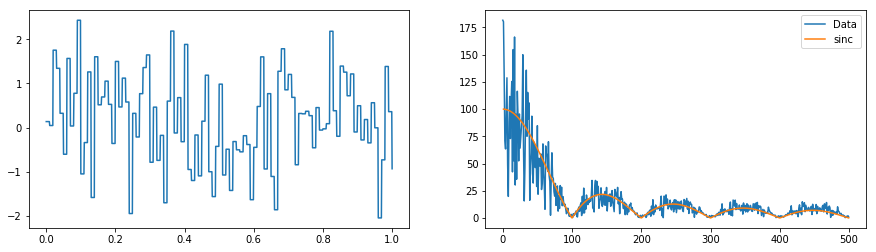

In [51]:
from scipy.interpolate import interp1d

dx = 1.0/100
x = np.arange(0,1+dx,dx)
y = np.random.normal(size=len(x))

interpolator = interp1d(x, y, kind='zero', axis=0)
dx = 1.0/1000
x = np.arange(0,1+dx,dx)
y = interpolator(x)

fig,ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(x,y)

f = np.fft.rfft(y)
fx = np.fft.rfftfreq(len(y),x[1]-x[0])
ax[1].plot(fx,abs(f), label='Data')
ax[1].plot(fx,abs(100*np.sin(np.pi/100*fx)/(np.pi/100*fx)), label='sinc')
plt.legend()
plt.show()

In [110]:
import nhmfl
from nhmfl.log import *

# Python allows us to define a function within another function. We use this to define a function
# to read the data, given a certain filename formula. It often happens that the filename formulas change
# between experiments, but the loading technique remains constant. Write it once and invoke it on any
# filename.
def data_loader(filename_formula):
    # construct appropriate loader function for this dataset
    
    # e is a dictionary of parameters.
    # Required parameters must be set:
    #   n : data serial number or identifier, passed to filename_formula
    #   filename_formula : lambda to compute filename from n
    def data_load_mapper(e):
        e['filename'] = filename_formula(e['n'])
        d = nhmfl.dcfield.NHMFL_DC_Data(e['filename'])
        d.clean_field(smoothing_time=3.0)
        e['df'] = d.df        
        return e

    return data_load_mapper

def temperature_formula(e):
    field = e['df']['Field'].values
    temp = e['df']['Probe_T'].values
    e['T'] = np.average(temp[(field>-0.01) & (field<0.01)])
    return e
    
    
filename_formula = lambda n : '/Users/coniglio/DataAnalysis/20150518_xcf_screening/raw/201505_cell9.{:0>3d}'.format(n)

# from a TDO measurement
e = Sample('sample a', column='Freq', loader=data_loader(filename_formula))

# example for a transport measurement
#e1 = Sample('sample a', Ixx='A_Rxx_I', Qxx='A_Rxx_Q', Ixy='A_Rxy_I', Qxy='A_Rxy_Q', Iac=100e-6, Fac='127.672', angle_mapper=Angle.identity, loader=data_loader(filename_formula))
#e2 = Sample('sample b', Ixx='B_Rxx_I', Qxx='B_Rxx_Q', Iac=100e-6, Fac='133.211', angle_mapper=Angle.fixed(0), loader=data_loader(filename_formula) )

p = nhmfl.log.Experiment()

p.inc(e)
p.date('May 26, 2015')
p.snap(n=8)
p.snap(n=51)
p.snap(n=61)

p = p.map(ExperimentVariableMapper('loader')) # load the data
p = p.map(temperature_formula)

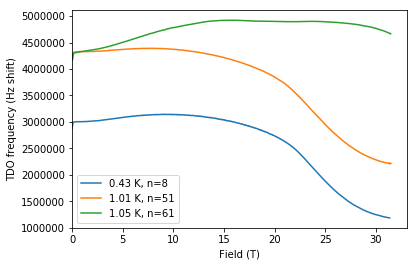

In [111]:
for e in p.save():
    df = e['df']
    plt.plot(df['Field'].values, df['Freq'].values, label='{:.2f} K, n={:d}'.format(e['T'],e['n']))

plt.xlabel('Field (T)')
plt.ylabel('TDO frequency (Hz shift)')
plt.xlim((0,None))
plt.legend()
plt.show()